In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cd drive/My Drive/algorithmtrading/pair_trading

[Errno 2] No such file or directory: 'drive/My Drive/algorithmtrading/pair_trading'
/content/drive/My Drive/algorithmtrading/pair_trading


In [ ]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin-1:end]

# 1. 과거 1분단위 데이터 받아오기

In [ ]:
now = '20210120'

samsung_group = pd.read_pickle('KODEX 200(m)_'+now)
kodex200 = pd.read_pickle('TIGER 200(m)_'+now)

temp =  pd.merge(left = samsung_group , right = kodex200, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['samsung_group','volume','kodex200','volume']
temp = temp[['samsung_group','kodex200']]

temp['samsung_group']=pd.to_numeric(temp['samsung_group'])
temp['kodex200']=pd.to_numeric(temp['kodex200'])

for i in range(len(temp)):
    if temp['samsung_group'].iloc[i] < 0:
        temp['samsung_group'].iloc[i] = -temp['samsung_group'].iloc[i]
    if temp['kodex200'].iloc[i] < 0:
        temp['kodex200'].iloc[i] = -temp['kodex200'].iloc[i]


temp['kodex200'] = temp['kodex200']
temp['spread'] = temp['samsung_group'] - temp['kodex200']
temp['samsung_group_cumret'] = np.log(temp['samsung_group']/temp['samsung_group'][0])
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])
temp['ma10_spread'] = temp['spread'].rolling(window=10, center=False).mean()

temp

,kodex200,tiger200,spread,kodex200_cumret,tiger200_cumret,ma10_spread
체결시간,,,,,,
20200102100000,29221,29176,45,0.000000,0.000000,nan
20200102100100,29192,29152,40,-0.000993,-0.000823,nan
20200102100200,29206,29166,40,-0.000513,-0.000343,nan
20200102100300,29192,29152,40,-0.000993,-0.000823,nan
20200102100400,29152,29112,40,-0.002364,-0.002196,nan
...,...,...,...,...,...,...
20210119151600,42700,42660,40,0.379311,0.379915,25.000000
20210119151700,42700,42675,25,0.379311,0.380267,25.000000
20210119151800,42720,42690,30,0.379780,0.380618,27.000000


# 2. 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [ ]:
df = {}
calender = []
for date in range(20201021,20210120):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['samsung_group_dayret'] = np.log(temps['samsung_group']/temps['samsung_group'][0])
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['spread_cumret'] = temps['samsung_group_cumret'] -temps['kodex200_cumret']
        temps['spread_dayret']= temps['samsung_group_dayret'] - temps['kodex200_dayret'] 
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

# 3. 그래프 그리기

In [ ]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    df[date]['spread'].plot()
    # df[date]['ma10_spread'].plot()
    # temp_high = df[date]['ma10_spread'] +20
    # temp_low = df[date]['ma10_spread']-20
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['samsung_group'].plot()
    # df[date]['kodex200'].plot()
    # plt.axhline((0.0003), color='red', linestyle='--')
    # plt.axhline((-0.0003), color='red', linestyle='--')
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
# temp['samsung_group_cumret'].plot()
# temp['samsung_group_cumret'].plot()
# temp['kodex200_cumret'].plot()
temp['samsung_group'].plot()
temp['kodex200'].plot()
# temp['ma30'].plot()

# 4. 스프레드 확인

In [4]:
cd bidask

/content/drive/My Drive/algorithmtrading/pair_trading/bidask


In [59]:
now = '20210122'

samsung_group_bidask = pd.read_pickle('KODEX 삼성그룹_'+now)
kodex200_bidask = pd.read_pickle('KODEX 200_'+now)

bidask =  pd.merge(left = samsung_group_bidask , right = kodex200_bidask, how = "inner", on = "time")
bidask.columns = ['samsung_group_bid','samsung_group_ask','kodex200_bid','kodex200_ask']
samsung_group_ask = bidask['samsung_group_ask']
samsung_group_bid = bidask['samsung_group_bid']
kodex200_ask = bidask['kodex200_ask']
kodex200_bid = bidask['kodex200_bid']
bidask

,samsung_group_bid,samsung_group_ask,kodex200_bid,kodex200_ask
time,,,,
095244,10800,10790,43525,43515
095249,10790,10785,43515,43510
095252,10795,10785,43515,43505
095259,10795,10785,43500,43495
095304,10795,10785,43495,43490
...,...,...,...,...
151929,10850,10840,43240,43235
151934,10850,10840,43250,43240
151947,10850,10840,43245,43235


## - bidask 스프레드

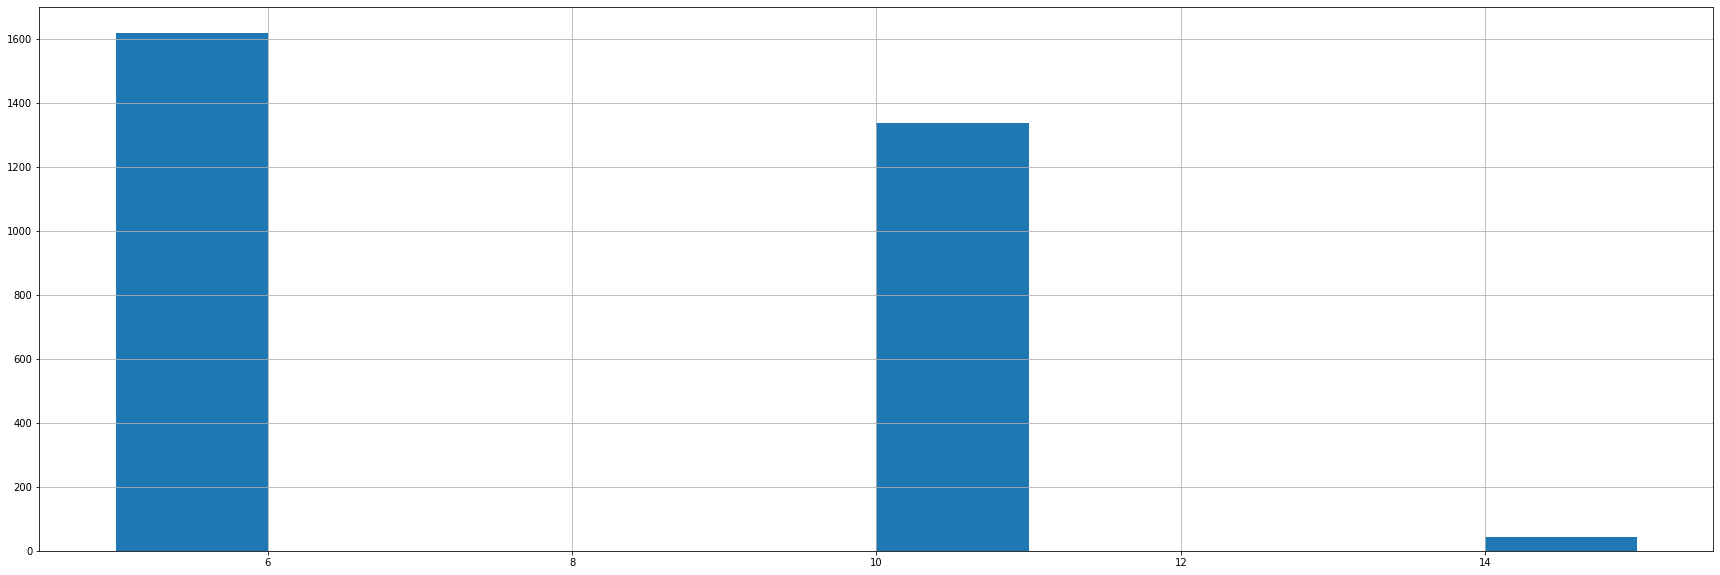

In [33]:
plt.rcParams["figure.figsize"] = (30, 10)
bidask_spread = kodex200_bid-kodex200_ask
bidask_spread.hist()

# kodex200_ask_samsung_group_bid spread freaquency    (청산포지션)

-32695    76
-32685    73
-32705    67
-32690    62
-32680    61
-32670    60
-32945    58
-32940    56
-32700    56
-32935    52
-32715    52
-32675    51
-32665    51
-32630    50
-32925    44
-32710    43
-32950    43
-32815    42
-32635    41
-32650    41
-32660    40
-32625    40
-32730    40
-32995    38
-32720    38
-32620    38
-32930    37
-32960    36
-32920    36
-32510    35
dtype: int64


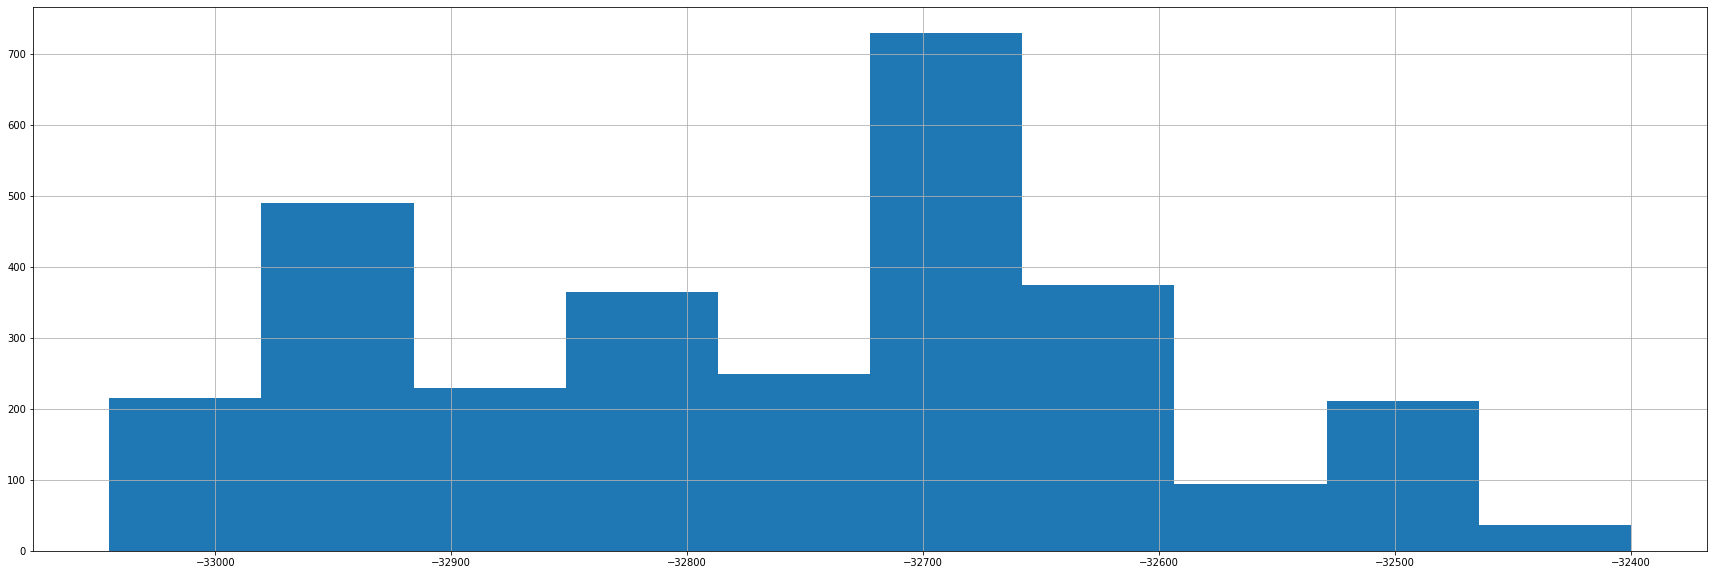

In [55]:
finish = samsung_group_ask - kodex200_bid
finish.hist()
finish = finish.value_counts() 
print(finish[:30])

# samsung_group_ask_kodex200_bid spread freaquency (포지션시작)

32930    74
32680    73
32655    63
32685    62
32675    62
32695    61
32660    60
32670    58
32690    54
32650    50
32665    50
32700    49
32610    48
32615    47
32925    46
32915    45
32640    44
32920    44
32910    44
32605    41
32705    39
32620    39
32980    37
32490    37
32645    37
32905    36
32720    36
32935    35
32800    35
32635    35
dtype: int64


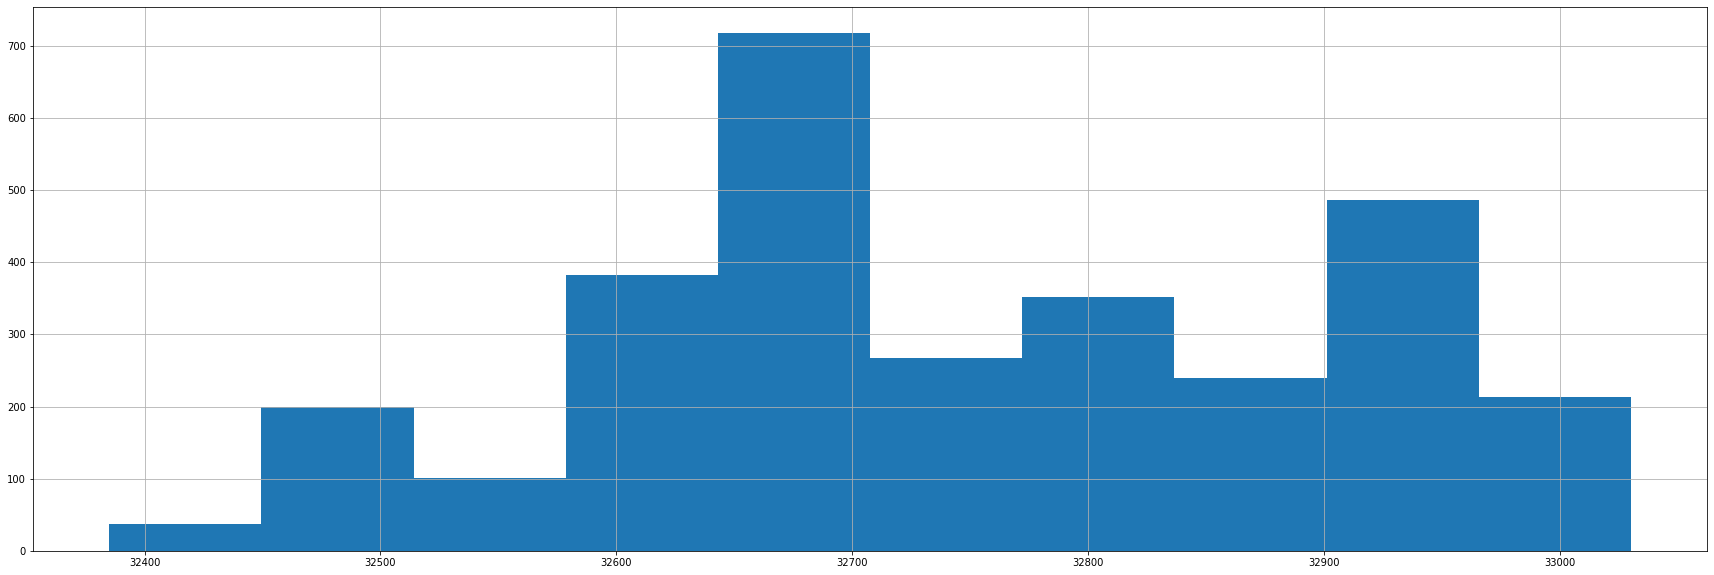

In [54]:
start = kodex200_ask - samsung_group_bid
start.hist()
start = start.value_counts() 
print(start[:30])

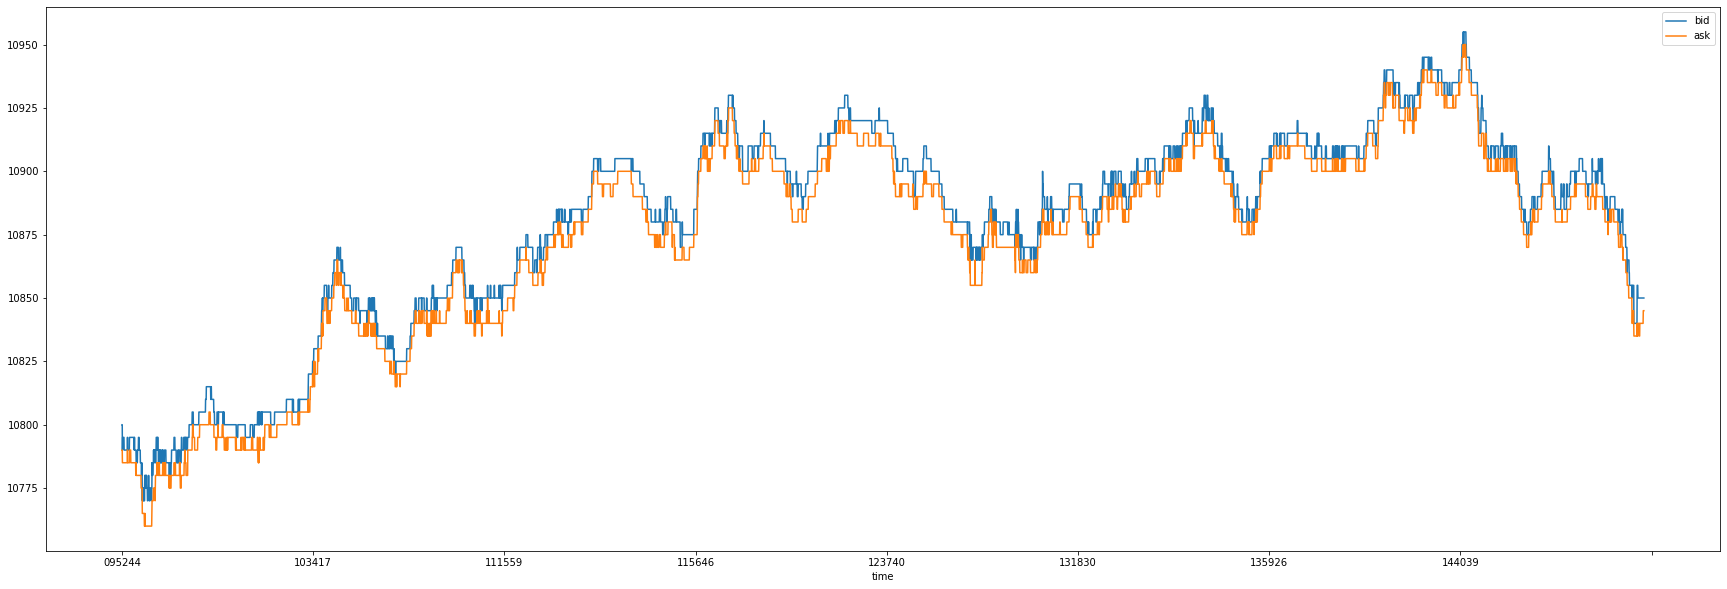

In [36]:
samsung_group_bidask.plot()

# 시뮬레이션

In [62]:
profit = 0
profits = {}

kodex = 20
tiger = 20

lev = 1

spread_start = list(map(int,start.index))
spread_finish = list(map(int,finish.index))

for j in spread_start[:30]:
    for k in spread_finish[:30]:
        if j + k < 0:
            continue
        profit = 0
        t = 0
        for i in range(len(bidask)):
            if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and tiger<=39:
                kodex -= lev
                tiger += lev
                profit += bidask['kodex200_ask'].iloc[i]*lev - bidask['samsung_group_bid'].iloc[i]*lev
                # print('start',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)
                t += 2
                continue
            if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and tiger > 20:
                profit += bidask['samsung_group_ask'].iloc[i]*(tiger - 20) - bidask['kodex200_bid'].iloc[i]*(tiger-20)
                tiger = 20
                kodex = 20
                # print('finish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)       
                t += 2
        profits[(j,k,t)] = profit - t*6
        # print('-------------------------------------------------------------------------------------------------------------------')

profits = sorted(profits.items(), key=lambda x: x[1], reverse=True)
profits[:20]

[((32980, -32510, 42), 9433),
 ((32935, -32510, 42), 8798),
 ((32930, -32510, 42), 8413),
 ((32925, -32510, 42), 8388),
 ((32915, -32510, 42), 8323),
 ((32920, -32510, 42), 8323),
 ((32910, -32510, 42), 8273),
 ((32905, -32510, 42), 8248),
 ((32980, -32620, 42), 7233),
 ((32980, -32630, 42), 7133),
 ((32980, -32625, 42), 7133),
 ((32980, -32635, 42), 6933),
 ((32980, -32650, 42), 6633),
 ((32935, -32620, 42), 6598),
 ((32980, -32660, 42), 6533),
 ((32935, -32630, 42), 6498),
 ((32935, -32625, 42), 6498),
 ((32980, -32665, 42), 6333),
 ((32935, -32635, 42), 6298),
 ((32980, -32670, 42), 6233)]